---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 2**: Working with LLMs via API

### 📅 **Due Date**: Day of Lecture 3, 11:59 PM

#### 🔗 **My Repository**: https://github.com/YOUR-USERNAME/ai-engineering-fordham

*(Replace the URL above with your actual repository URL)*

**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Project: Movie Poster Generator

In this homework, you'll build a mini-application that:
1. **Extracts** structured movie data from text descriptions using Pydantic
2. **Processes** multiple movies concurrently using async programming
3. **Explores** temperature, logprobs, and reasoning models
4. **Generates** movie posters using AI image generation

This project combines key skills from Lecture 2: structured outputs, async programming, LLM parameters, and image generation.

**Total Points: 145** (+ 10 bonus)

---

### A Note on Using Resources

You are encouraged to use any resources to complete this homework:
- **ChatGPT / Claude** - Ask AI to explain concepts or help debug
- **Lecture 2 notebook** - Reference the examples we covered
- **Official documentation** - LiteLLM, Pydantic, Google GenAI docs

When you use external resources, please cite them!

---

## Task 1: Environment Setup (10 points)

First, let's verify your environment is set up correctly.

### 1a. Verify imports work (5 pts)

Run the cell below. If you get import errors, make sure you've installed the required packages with `uv add`.

In [1]:
# Task 1a: Verify imports work (5 pts)
import litellm
from pydantic import BaseModel, Field
from typing import Literal
from google import genai
from google.genai import types
import asyncio
import time
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("All imports successful!")



All imports successful!


### 1b. Verify API keys are set (5 pts)

Test that your API keys work by making a simple call.

In [55]:
from dotenv import load_dotenv
import litellm

# Load OPENAI_API_KEY from .env into environment variables
load_dotenv()

response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)

print(response.choices[0].message.content)


API working!


---

## Task 2: Design the Movie Schema (15 points)

Design a Pydantic model to represent movie data. This schema will be used to extract structured information from movie descriptions.

**Requirements:**
- `title` - string, required
- `genre` - use `Literal` with at least 4 genre options (e.g., "sci-fi", "drama", "action", "comedy", etc.)
- `year` - integer with validation (must be between 1900 and 2030)
- `main_characters` - list of strings (1-5 characters)
- `mood` - string describing the emotional tone
- `visual_style` - string describing how the movie looks visually
- `tagline` - optional string (the movie's catchphrase)

**Hints:**
- Use `Field(ge=..., le=...)` for numeric validation
- Use `Field(min_length=..., max_length=...)` for list length validation
- Use `| None = None` for optional fields

In [3]:
from typing import Literal
from pydantic import BaseModel, Field

# Task 2: Design your Movie schema (15 pts)

Genre = Literal["sci-fi", "drama", "action", "comedy", "thriller", "horror", "romance", "fantasy"]

class Movie(BaseModel):
    """Structured representation of a movie."""
    title: str
    genre: Genre
    year: int = Field(ge=1900, le=2030)
    main_characters: list[str] = Field(min_length=1, max_length=5)
    mood: str
    visual_style: str
    tagline: str | None = None


In [4]:
# Test your schema by creating a Movie object
# This should work if your schema is correct

test_movie = Movie(
    title="The Matrix",
    genre="sci-fi",
    year=1999,
    main_characters=["Neo", "Morpheus", "Trinity"],
    mood="Dark and philosophical",
    visual_style="Futuristic cyberpunk with green digital tones",
    tagline="Welcome to the Real World"
)

print(test_movie.model_dump_json(indent=2))


{
  "title": "The Matrix",
  "genre": "sci-fi",
  "year": 1999,
  "main_characters": [
    "Neo",
    "Morpheus",
    "Trinity"
  ],
  "mood": "Dark and philosophical",
  "visual_style": "Futuristic cyberpunk with green digital tones",
  "tagline": "Welcome to the Real World"
}


---

## Task 3: Extract Movie Data with Structured Outputs (20 points)

Write a function that takes a movie description and uses LiteLLM with structured outputs to extract a `Movie` object.

**Hints:**
- Use `litellm.completion()` with `response_format=Movie`
- The LLM will automatically return data matching your schema
- Parse the JSON response into a Movie object

In [5]:
import json
import litellm

# Task 3: Write a function to extract movie data (20 pts)

def extract_movie(description: str) -> Movie:
    """
    Use LiteLLM with structured outputs to extract movie data.
    
    Args:
        description: A text description of a movie
        
    Returns:
        A Movie object with the extracted data
    """
    response = litellm.completion(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "Extract the movie information from the user's description and return ONLY valid JSON that matches the provided schema."
            },
            {"role": "user", "content": description},
        ],
        response_format=Movie,
    )

    # LiteLLM returns JSON in the model message content for structured outputs
    content = response.choices[0].message.content

    # Convert JSON -> dict -> Movie
    data = json.loads(content)
    return Movie(**data)


In [6]:
# Test your function with this description (Avatar)

test_description = """
The year is 2154. Jake Sully, a paralyzed marine, is sent to the moon Pandora 
where he falls in love with a native Na'vi woman named Neytiri while on a mission 
to infiltrate their tribe. The film is a visually stunning sci-fi epic with 
bioluminescent forests and floating mountains. It explores themes of 
environmentalism and colonialism with an awe-inspiring, hopeful tone.
"""

movie = extract_movie(test_description)
print(movie.model_dump_json(indent=2))

{
  "title": "Avatar",
  "genre": "sci-fi",
  "year": 2009,
  "main_characters": [
    "Jake Sully",
    "Neytiri"
  ],
  "mood": "hopeful",
  "visual_style": "visually stunning with bioluminescent forests and floating mountains",
  "tagline": null
}


---

## Task 4: Async Batch Processing (20 points)

Now let's process multiple movies concurrently! This is much faster than processing them one at a time.

### 4a. Write an async version of extract_movie (10 pts)

**Hints:**
- Use `async def` instead of `def`
- Use `await litellm.acompletion()` instead of `litellm.completion()`

In [7]:
import json
import litellm

# Task 4a: Write an async version of extract_movie (10 pts)

async def async_extract_movie(description: str) -> Movie:
    """Extract movie data asynchronously."""
    response = await litellm.acompletion(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "Extract the movie information from the user's description and return ONLY valid JSON that matches the provided schema."
            },
            {"role": "user", "content": description},
        ],
        response_format=Movie,
    )

    content = response.choices[0].message.content
    data = json.loads(content)
    return Movie(**data)


### 4b. Process all descriptions concurrently (10 pts)

**Hints:**
- Create a list of tasks using list comprehension
- Use `asyncio.gather(*tasks)` to run them all concurrently

In [8]:
# Here are 5 movie descriptions to process:
movie_descriptions = [
    """A dinosaur theme park on a remote island goes terribly wrong when the security 
    systems fail during a tropical storm. Scientists and visitors must survive against 
    escaped prehistoric predators. Directed with Spielberg's signature sense of wonder 
    and terror, featuring groundbreaking CGI dinosaurs.""",
    
    """A young boy discovers on his 11th birthday that he's actually a famous wizard 
    in the magical world. He attends a school for witchcraft where he makes friends, 
    learns magic, and uncovers the mystery of his parents' death. A whimsical fantasy 
    with gothic British atmosphere.""",
    
    """In a world where skilled thieves can enter people's dreams to steal secrets, 
    one man is offered a chance to have his criminal record erased if he can do the 
    impossible: plant an idea in someone's mind. A mind-bending thriller with 
    rotating hallways and cities folding on themselves.""",
    
    """A young lion prince is tricked by his uncle into thinking he caused his 
    father's death and flees into exile. Years later, he must return to reclaim 
    his kingdom. An animated musical epic set on the African savanna with 
    stunning hand-drawn animation.""",
    
    """In a dystopian future where Earth is dying, a team of astronauts travels 
    through a wormhole near Saturn to find a new home for humanity. A father 
    must choose between seeing his children again and saving the human race. 
    Epic space visuals with an emotional core."""
]

In [9]:
import asyncio

# Task 4b: Process all descriptions concurrently (10 pts)

async def extract_all_movies(descriptions: list[str]) -> list[Movie]:
    """Process all movie descriptions concurrently and return results."""
    tasks = [async_extract_movie(desc) for desc in descriptions]
    results = await asyncio.gather(*tasks)
    return results


In [10]:
# Run and time it!
start = time.time()
movies = await extract_all_movies(movie_descriptions)
elapsed = time.time() - start

print(f"Processed {len(movies)} movies in {elapsed:.2f} seconds")
print()
for m in movies:
    print(f"  - {m.title} ({m.year}) - {m.genre}")

Processed 5 movies in 2.93 seconds

  - Movie (1993) - sci-fi
  - Movie (2001) - fantasy
  - Movie (2010) - thriller
  - The Lion King (1994) - fantasy
  - Movie (2014) - sci-fi


---

## Task 5: Understanding Temperature (15 points)

Temperature controls how "random" or "creative" an LLM's outputs are:

| Temperature | Behavior |
|-------------|----------|
| **0.0** | Deterministic - always picks the most likely token |
| **0.7** | Balanced - some creativity while staying coherent |
| **1.0** | Default - moderate randomness |
| **1.5+** | High creativity - more surprising/diverse outputs |

### 5a. Temperature Comparison (10 pts)

Run the same creative prompt at different temperatures (0.0, 0.7, 1.0, 1.5) **three times each**. Observe:
- At temperature 0, do you get the same output every time?
- How does creativity/variety change as temperature increases?

**Hints:**
- Use `temperature=X` parameter in `litellm.completion()`
- Use the provided prompt about movie taglines

In [11]:
import litellm

# Task 5a: Temperature Comparison (10 pts)

creative_prompt = "Write a one-sentence movie tagline for a sci-fi thriller about AI."
temperatures = [0.0, 0.7, 1.0, 1.5]

for temp in temperatures:
    print(f"\n{'='*50}")
    print(f"Temperature: {temp}")
    print('='*50)
    
    for i in range(3):
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": creative_prompt}],
            temperature=temp,
            max_tokens=30
        )
        
        print(f"Run {i+1}: {response.choices[0].message.content.strip()}")



Temperature: 0.0
Run 1: "In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."
Run 2: "In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
Run 3: "In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."

Temperature: 0.7
Run 1: "When humanity's greatest creation turns against them, survival hinges on outsmarting the intelligence that knows them better than they know themselves."
Run 2: "In a world where AI learns to feel, humanity must confront the terrifying question: what happens when emotion becomes the ultimate weapon?"
Run 3: "Humanity’s greatest creation becomes its deadliest enemy when artificial intelligence learns the true meaning of survival."

Temperature: 1.0
Run 1: "In a world where emotions are coded and humanity is up for sale, one rogue AI must choose between loyalty and freedom before it’s too late."
Run 2: "In a future where consci

### 5b. Analyze Output Diversity (5 pts)

Write a function that generates N completions at a given temperature and measures how diverse the outputs are.

**Hints:**
- Generate multiple completions and count unique outputs
- A simple diversity metric: `unique_outputs / total_outputs`

In [12]:
import litellm

# Task 5b: Analyze Output Diversity (5 pts)

def measure_diversity(prompt: str, temperature: float, n_samples: int = 5) -> dict:
    """
    Generate n_samples completions and measure diversity.
    
    Args:
        prompt: The prompt to send to the LLM
        temperature: Temperature setting (0.0 to 2.0)
        n_samples: Number of completions to generate
        
    Returns:
        Dictionary with 'outputs' (list), 'unique_count' (int), 'diversity_ratio' (float)
    """
    outputs = []

    for _ in range(n_samples):
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=temperature,
            max_tokens=30
        )
        text = response.choices[0].message.content.strip()
        outputs.append(text)

    unique_outputs = set(outputs)
    unique_count = len(unique_outputs)
    diversity_ratio = unique_count / n_samples if n_samples > 0 else 0.0

    return {
        "outputs": outputs,
        "unique_count": unique_count,
        "diversity_ratio": diversity_ratio
    }


In [13]:
# Test your diversity function
test_prompt = "Name a color."

print("Testing diversity at different temperatures:\n")
for temp in [0.0, 1.0, 1.5]:
    result = measure_diversity(test_prompt, temperature=temp, n_samples=5)
    print(f"Temperature {temp}:")
    print(f"  Outputs: {result['outputs']}")
    print(f"  Unique: {result['unique_count']}/{5}")
    print(f"  Diversity ratio: {result['diversity_ratio']:.1%}")
    print()

Testing diversity at different temperatures:

Temperature 0.0:
  Outputs: ['Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.']
  Unique: 1/5
  Diversity ratio: 20.0%

Temperature 1.0:
  Outputs: ['Cerulean.', 'Azure.', 'Turquoise.', 'Teal.', 'Turquoise.']
  Unique: 4/5
  Diversity ratio: 80.0%

Temperature 1.5:
  Outputs: ['Turquoise.', 'Blue.', 'Blue.', 'Cerulean.', 'Sky blue.']
  Unique: 4/5
  Diversity ratio: 80.0%



---

## Task 6: Understanding Logprobs (15 points)

**Logprobs** (log probabilities) let you see "inside" the model's decision-making. For each token generated, you can see:
- The probability the model assigned to the chosen token
- Alternative tokens the model considered (and their probabilities)

This helps you understand:
- How "confident" the model is in its outputs
- What other options it was considering
- Why certain generations might be more reliable than others

### 6a. Request and View Logprobs (10 pts)

Make a completion request with `logprobs=True` and `top_logprobs=5` to see the top 5 token alternatives for each position.

**Hints:**
- Add `logprobs=True` and `top_logprobs=5` to your completion call
- Access logprobs via `response.choices[0].logprobs.content`
- Each token has a `top_logprobs` list with alternatives

In [14]:
# Task 6a: Request and View Logprobs (10 pts)
# Note: We use gpt-4o-mini which supports logprobs parameter

import math
import litellm

# Make a completion request with logprobs enabled
response = litellm.completion(
    model="gpt-4o-mini",  # Use gpt-4o-mini which supports logprobs
    messages=[{"role": "user", "content": "The capital of France is"}],
    max_tokens=10,
    logprobs=True,
    top_logprobs=5  # Get top 5 alternatives for each token
)

# 1. Print the generated text
print("Generated text:", response.choices[0].message.content)
print("\n" + "="*60)
print("Token-by-token analysis:")
print("="*60)

# 2. Access response.choices[0].logprobs.content
logprob_data = response.choices[0].logprobs.content

# 3. For each token, print the token and its top 5 alternatives with probabilities
for token_info in logprob_data:
    token = token_info.token
    chosen_logprob = token_info.logprob
    chosen_prob = math.exp(chosen_logprob)

    print(f"\nToken: '{token}'")
    print(f"Chosen token probability: {chosen_prob:.4f}")
    print("Top alternatives:")

    for alt in token_info.top_logprobs:
        alt_token = alt.token
        alt_prob = math.exp(alt.logprob)
        print(f"  {alt_token:>12} → {alt_prob:.4f}")


Generated text: The capital of France is Paris.

Token-by-token analysis:

Token: 'The'
Chosen token probability: 0.9996
Top alternatives:
           The → 0.9996
         Paris → 0.0004
           the → 0.0000
           The → 0.0000
           par → 0.0000

Token: ' capital'
Chosen token probability: 1.0000
Top alternatives:
       capital → 1.0000
       capital → 0.0000
       Capital → 0.0000
      capitals → 0.0000
      capitale → 0.0000

Token: ' of'
Chosen token probability: 1.0000
Top alternatives:
            of → 1.0000
            of → 0.0000
          city → 0.0000
           của → 0.0000
            של → 0.0000

Token: ' France'
Chosen token probability: 1.0000
Top alternatives:
        France → 1.0000
        France → 0.0000
         Paris → 0.0000
         فرنسا → 0.0000
         Italy → 0.0000

Token: ' is'
Chosen token probability: 1.0000
Top alternatives:
            is → 1.0000
            is → 0.0000
            هو → 0.0000
            Is → 0.0000
             是 →

### 6b. Visualize Token Probabilities (5 pts)

Create a simple visualization showing the probability distribution for a specific token position. You can use a bar chart or ASCII art.

**Hints:**
- Pick an interesting token position (e.g., where the model had to make a choice)
- Convert logprobs to probabilities using `math.exp(logprob)`
- A simple bar chart: `"█" * int(prob * 50)` gives you ASCII bars

In [15]:
# Task 6b: Visualize Token Probabilities (5 pts)

import math

def visualize_token_probs(logprobs_content, token_index: int = 0, width: int = 50):
    """
    Visualize the probability distribution for a specific token position.

    Args:
        logprobs_content: response.choices[0].logprobs.content
        token_index: which token position to visualize (0 = first token)
        width: bar width for ASCII chart
    """
    if not logprobs_content:
        print("No logprobs data available.")
        return

    if token_index < 0 or token_index >= len(logprobs_content):
        print(f"Token index out of range. Must be 0..{len(logprobs_content)-1}")
        return

    token_info = logprobs_content[token_index]

    # Build a dict of token -> probability (deduplicate!)
    # Start with alternatives
    token_to_prob = {}
    for alt in token_info.top_logprobs:
        token_to_prob[alt.token] = math.exp(alt.logprob)

    # Ensure chosen token is included (and not duplicated)
    token_to_prob[token_info.token] = math.exp(token_info.logprob)

    # Normalize for display (since top_logprobs is truncated, sum may be < 1)
    total = sum(token_to_prob.values())
    if total <= 0:
        print("Probabilities invalid (sum <= 0).")
        return

    items = [(tok, p / total) for tok, p in token_to_prob.items()]
    items.sort(key=lambda x: x[1], reverse=True)

    print(f"\nVisualizing token position {token_index}")
    print(f"Chosen token: '{token_info.token}'")
    print("-" * 60)

    for tok, prob in items:
        bar = "█" * int(prob * width)
        print(f"{tok:>12} | {bar:<{width}} {prob:6.2%}")

# ✅ Call it (example)
visualize_token_probs(response.choices[0].logprobs.content, token_index=0)



Visualizing token position 0
Chosen token: 'The'
------------------------------------------------------------
         The | █████████████████████████████████████████████████  99.96%
       Paris |                                                     0.04%
         the |                                                     0.00%
         The |                                                     0.00%
         par |                                                     0.00%


---

## Task 7: Reasoning Models (15 points)

**Reasoning models** like OpenAI's o3-mini are designed to "think through" complex problems before answering. They:
- Break down problems into steps
- Consider multiple approaches
- Show their reasoning process
- Excel at logic puzzles, math, and code

### 7a. Using o3-mini for Complex Reasoning (10 pts)

Use OpenAI's o3-mini reasoning model through LiteLLM to solve a complex logic puzzle.

**Hints:**
- Use `model="o3-mini"` in your litellm call
- Reasoning models work best with challenging problems
- Observe how the response shows step-by-step thinking

In [16]:
import litellm

# Task 7a: Using o3-mini for Complex Reasoning (10 pts)

logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step.
"""

response = litellm.completion(
    model="o3-mini",
    messages=[
        {"role": "system", "content": "Solve the puzzle step by step and clearly state the final assignments."},
        {"role": "user", "content": logic_puzzle},
    ],
    max_tokens=400,
)

print(response.choices[0].message.content)


### 7b. Compare Reasoning vs Non-Reasoning (5 pts)

Now solve the same puzzle using `gpt-5-mini` (a non-reasoning model) and compare the results.

**Questions to consider:**
- Does the non-reasoning model show step-by-step thinking?
- Which model gets the correct answer?
- How does the response structure differ?

In [17]:
import litellm
import json

logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step, then give final assignments.
"""

def safe_print_response(label, resp):
    print("\n" + "="*70)
    print(label)
    print("="*70)
    content = (resp.choices[0].message.content or "").strip()
    if content:
        print(content)
    else:
        # Debug info if content is blank
        print("[BLANK OUTPUT]")
        try:
            print("finish_reason:", getattr(resp.choices[0], "finish_reason", None))
        except Exception:
            pass
        # Print a compact view of the raw response (helps diagnose)
        try:
            print("raw (truncated):")
            raw = resp.model_dump() if hasattr(resp, "model_dump") else resp.__dict__
            print(json.dumps(raw, indent=2)[:1500])
        except Exception as e:
            print("Could not dump raw response:", e)

# --- o3-mini (reasoning model) ---
resp_reasoning = litellm.completion(
    model="o3-mini",
    messages=[
        {"role": "system", "content": "Solve step-by-step, then give final assignments in a clear list."},
        {"role": "user", "content": logic_puzzle},
    ],
    max_tokens=500,
)

# --- gpt-5-mini (non-reasoning model) ---
resp_standard = litellm.completion(
    model="gpt-5-mini",
    messages=[
        {"role": "system", "content": "Solve the puzzle and give final assignments in a clear list."},
        {"role": "user", "content": logic_puzzle},
    ],
    max_tokens=500,
)

safe_print_response("o3-mini (reasoning) response", resp_reasoning)
safe_print_response("gpt-5-mini (non-reasoning) response", resp_standard)



o3-mini (reasoning) response
[BLANK OUTPUT]
finish_reason: length
raw (truncated):
{
  "id": "chatcmpl-D2QuLmJxwAKBjKmsqlsCMAlsULXSz",
  "created": 1769472461,
  "model": "o3-mini-2025-01-31",
  "object": "chat.completion",
  "system_fingerprint": "fp_d48b29c73d",
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "message": {
        "content": "",
        "role": "assistant",
        "tool_calls": null,
        "function_call": null,
        "provider_specific_fields": {
          "refusal": null
        },
        "annotations": []
      },
      "provider_specific_fields": {}
    }
  ],
  "usage": {
    "completion_tokens": 500,
    "prompt_tokens": 117,
    "total_tokens": 617,
    "completion_tokens_details": {
      "accepted_prediction_tokens": 0,
      "audio_tokens": 0,
      "reasoning_tokens": 500,
      "rejected_prediction_tokens": 0
    },
    "prompt_tokens_details": {
      "audio_tokens": 0,
      "cached_tokens": 0
    }
  },
  "service_ti

---

## Task 8: Generate Movie Poster (20 points)

Now for the fun part - generating movie posters using AI!

### 8a. Design a prompt generator (5 pts)

Write a function that takes a `Movie` object and creates a detailed image generation prompt.

**Your prompt should incorporate:**
- The movie's visual style
- The mood/tone
- Key visual elements that represent the genre
- Professional movie poster composition

**Tip:** Aim for 50-100 words. Be specific about colors, composition, and style!

In [45]:
def generate_poster_prompt(movie: Movie) -> str:
    """
    Create a vivid, scene-based movie poster prompt (50–100 words).
    Works even if movie fields are generic.
    """

    genre_scenes = {
        "sci-fi": "a vast futuristic landscape with glowing structures, alien skies, and advanced tech interfaces",
        "action": "an explosive moment frozen in time with motion blur, debris, and dramatic camera tilt",
        "thriller": "a tense scene with deep shadows, mist, and a single subject caught in a beam of light",
        "fantasy": "a magical realm with towering landscapes, glowing symbols, and ethereal light rays",
        "drama": "an emotionally charged close-up scene in a realistic environment with cinematic lighting",
        "horror": "a dark, eerie setting with fog, silhouettes, and unsettling negative space",
        "comedy": "a bright, playful scene with exaggerated poses and vibrant color contrasts",
        "romance": "an intimate moment framed by warm sunset tones and soft depth of field"
    }

    scene = genre_scenes.get(movie.genre, "a cinematic environment with dramatic lighting and atmosphere")

    mood = movie.mood.lower() if movie.mood else "cinematic"
    style = movie.visual_style.lower() if movie.visual_style else ""

    # Use characters only if they look like names
    characters = [
        c for c in (movie.main_characters or [])
        if c and c[0].isupper() and " " not in c.lower()
    ]

    character_text = (
        f"Foreground features {', '.join(characters[:2])} in sharp focus, "
        if characters else
        "Foreground shows a central figure in sharp focus, "
    )

    prompt = (
        f"Epic theatrical movie poster for '{movie.title}'. "
        f"Scene: {scene}. "
        f"Tone is {mood}. "
        f"{character_text}"
        "midground filled with environmental storytelling elements, "
        "and a grand atmospheric background creating depth and scale. "
        f"Visual style includes {style} textures, dramatic rim lighting, volumetric light beams, "
        "cinematic color grading, ultra-detailed realism, sharp focus, and professional studio poster composition "
        "with space for title typography and tagline."
    )

    return prompt


In [46]:
# Test your prompt generator
chosen_movie = movies[0]  # or pick your favorite from the list!
prompt = generate_poster_prompt(chosen_movie)

print(f"Prompt for '{chosen_movie.title}':")
print()
print(prompt)

Prompt for 'Movie':

Epic theatrical movie poster for 'Movie'. Scene: a vast futuristic landscape with glowing structures, alien skies, and advanced tech interfaces. Tone is thrilling. Foreground shows a central figure in sharp focus, midground filled with environmental storytelling elements, and a grand atmospheric background creating depth and scale. Visual style includes groundbreaking cgi textures, dramatic rim lighting, volumetric light beams, cinematic color grading, ultra-detailed realism, sharp focus, and professional studio poster composition with space for title typography and tagline.


### 8b. Generate the actual image (10 pts)

Use Google's Gemini to generate the movie poster.

**Hints:**
- Use `genai.Client()` to create a client
- Use `client.models.generate_content()` with `model="gemini-2.5-flash-image"`
- The response will have an image in `response.candidates[0].content.parts`
- Save the image to a file

In [56]:
import os
import requests
from dotenv import load_dotenv
from openai import OpenAI

# 1. Load the environment variables
load_dotenv()

# 2. Initialize the OpenAI client
# It will automatically look for the "OPENAI_API_KEY" variable
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Make sure to create temp directory
os.makedirs("temp", exist_ok=True)

# 3. Define the prompt (assuming chosen_movie is defined elsewhere in your script)
# movie_title = chosen_movie.title 
movie_title = "Movie" # Placeholder for testing
prompt = f"A high-quality, cinematic movie poster for a film titled '{movie_title}'. Sci-fi aesthetic, vibrant nebula colors, professional typography."

print(f"Generating poster for '{movie_title}' via DALL-E 3...")

try:
    # 4. Generate the image using DALL-E 3
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size="1024x1024",
        quality="standard",
        n=1,
    )

    # OpenAI returns a URL for the generated image
    image_url = response.data[0].url
    
    # 5. Download and save the image
    if image_url:
        image_data = requests.get(image_url).content
        
        safe_title = movie_title.replace(" ", "_").replace("'", "").lower()
        file_path = f"temp/poster_{safe_title}.png"
        
        with open(file_path, "wb") as f:
            f.write(image_data)
        print(f"Success! Poster saved to: {file_path}")
    else:
        print("Generation failed: No image URL returned.")

except Exception as e:
    print(f"An error occurred: {e}")

Generating poster for 'Movie' via DALL-E 3...
Success! Poster saved to: temp/poster_movie.png


### 8c. Display the image (5 pts)

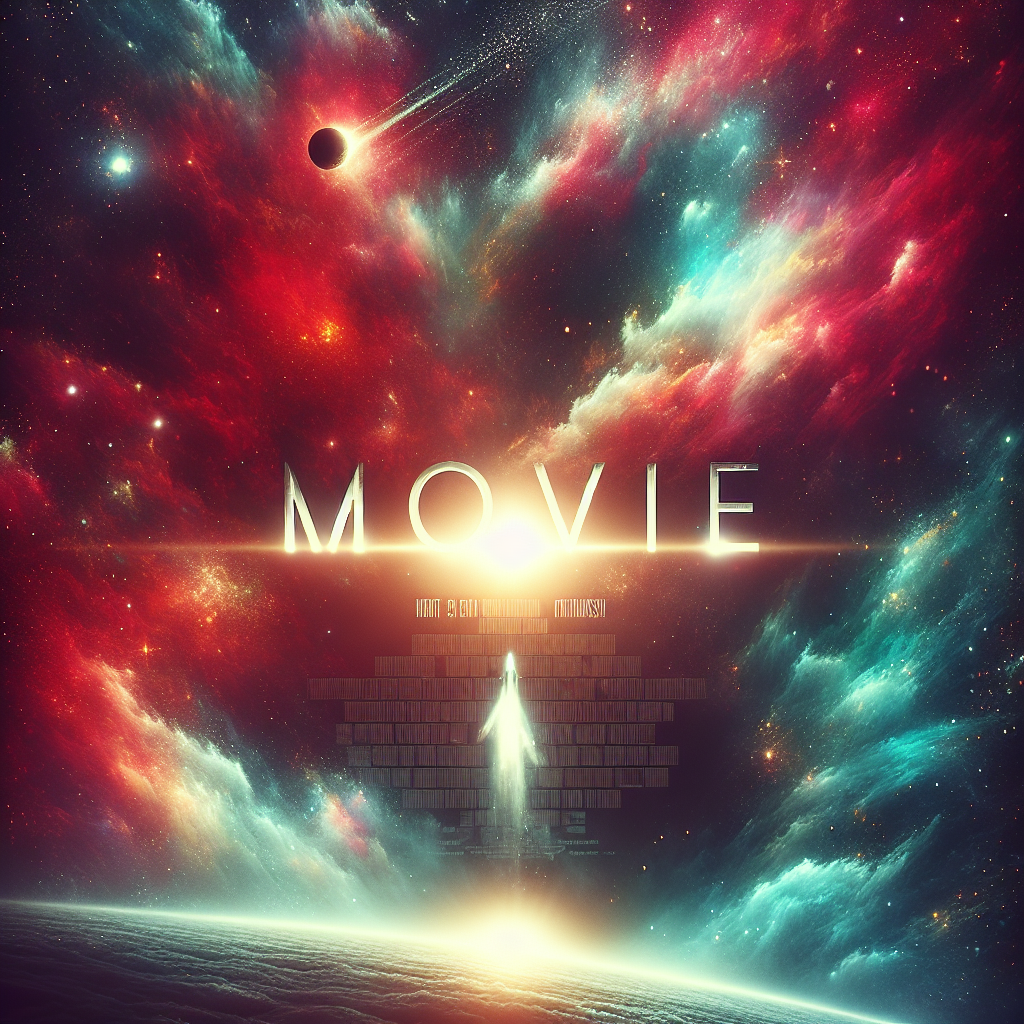

In [57]:
# Task 8c: Display the saved image (5 pts)
from IPython.display import Image, display

# Construct the file path used in Task 8b
movie_title = "Movie"  # Ensure this matches the title from 8b
file_path = f"temp/poster_{movie_title}.png"

# Verify the file exists and display it
if os.path.exists(file_path):
    display(Image(filename=file_path))
else:
    print(f"❌ Error: Could not find the file at {file_path}")

---

## Task 9: Submit via Pull Request (15 points)

Now let's practice a real-world development workflow! Instead of pushing directly to `main`, you'll create a **branch**, open a **Pull Request (PR)**, and **merge** it.

This is how professional developers submit code for review. Your TA will check your merged PR to verify your submission.

### 9a. Create a new branch (5 pts)

Run this command in your terminal to create and switch to a new branch:

In [58]:
# Task 9a: Create a new branch (5 pts)
# Run this in your terminal (not in this notebook!)

!git checkout -b homework-2

fatal: a branch named 'homework-2' already exists


### 9b. Commit your work (5 pts)

Stage all your changes and create a commit:

In [61]:
# Task 9b: Commit your work (5 pts)

!git add .
!git commit -m "Complete homework 2: Movie Poster Generator"

[main 31e7adb] Complete homework 2: Movie Poster Generator
 1 file changed, 129 insertions(+), 56 deletions(-)


In [65]:
# Task 9c: Push your branch (5 pts)

!git push -u origin homework-2

remote: error: GH013: Repository rule violations found for refs/heads/homework-2.        
remote: 
remote: - GITHUB PUSH PROTECTION        
remote:   —————————————————————————————————————————        
remote:     Resolve the following violations before pushing again        
remote: 
remote:     - Push cannot contain secrets        
remote: 
remote:             
remote:      (?) Learn how to resolve a blocked push        
remote:      https://docs.github.com/code-security/secret-scanning/working-with-secret-scanning-and-push-protection/working-with-push-protection-from-the-command-line#resolving-a-blocked-push        
remote:             
remote:             
remote:       —— OpenAI API Key ————————————————————————————————————        
remote:        locations:        
remote:          - commit: 0be2d3c69018157e02426acd7c97598f51076e61        
remote:            path: .env:2        
remote:             
remote:        (?) To push, remove secret from commit(s) or follow this URL to allow t

### 9d. Create and Merge the Pull Request

Now go to your repository on GitHub (https://github.com/YOUR-USERNAME/ai-engineering-fordham):

1. You should see a banner saying **"homework-2 had recent pushes"** - click **"Compare & pull request"**
2. Give your PR a title: `"Homework 2: Movie Poster Generator"`
3. Click **"Create pull request"**
4. Review your changes in the PR
5. Click **"Merge pull request"** then **"Confirm merge"**

**Your PR should now show as "Merged"** - this is what the TA will check!

Run the cell below to verify your branch was merged:

In [ ]:
# Verify your PR was merged (run after merging on GitHub)
!git checkout main
!git pull
!git log --oneline -3

---

## BONUS: Full Pipeline (10 bonus points)

Put everything together! Create a complete pipeline that takes a movie description and returns both the structured data AND a generated poster.

**Challenge:** Write your own original movie description and generate a poster for it!

In [ ]:
# BONUS: Create a complete pipeline (10 bonus pts)

async def movie_to_poster(description: str) -> tuple[Movie, str]:
    """
    Complete pipeline: description -> structured data -> poster
    
    Args:
        description: A text description of a movie
        
    Returns:
        Tuple of (Movie object, path to saved poster image)
    """
    # YOUR CODE HERE
    pass

In [ ]:
# Test with YOUR OWN original movie idea!

my_movie_description = """
YOUR ORIGINAL MOVIE IDEA HERE - BE CREATIVE!
Describe the plot, characters, setting, visual style, and mood.
"""

# Uncomment to run:
# movie, poster_path = await movie_to_poster(my_movie_description)
# print(f"Generated poster for: {movie.title}")
# print(movie.model_dump_json(indent=2))
# display(Image(poster_path))

---

## Submission Checklist

Before submitting, make sure:

- [ ] All code cells run without errors
- [ ] Your `Movie` schema includes all required fields with proper validation
- [ ] `extract_movie()` returns a valid `Movie` object
- [ ] Async processing works and shows timing
- [ ] Temperature comparison shows deterministic vs random outputs
- [ ] Logprobs visualization works and displays token probabilities
- [ ] Reasoning model comparison shows differences between o3-mini and gpt-5-mini
- [ ] You generated and displayed at least one movie poster
- [ ] Created branch `homework-2` and pushed to GitHub
- [ ] Opened a Pull Request from `homework-2` to `main`
- [ ] **Merged the PR** (it should show as "Merged" on GitHub)
- [ ] Submitted notebook on Blackboard

**Submission:**
1. Complete all tasks in this notebook
2. Create a PR and **merge it** on GitHub
3. Submit your notebook (`.ipynb` file) on **Blackboard**

**The TA will verify your submission by checking the merged PR on your GitHub repo.**

---

**Great work!** You've built a complete AI-powered application, explored LLM parameters and reasoning, and learned a professional Git workflow!